# Notebook 5 — Pathway Enrichment Analysis

**Goal:** Convert differential expression (DE) results generated in Notebook 4 into pathway-level insights by running gene set enrichment analysis (GSEA) on a ranked list of all genes.

**Why GSEA?**
- Enrichment on a *ranked* gene list captures subtle but coordinated pathway shifts that may be missed when only looking at hard DE thresholds (Subramanian et al., 2005).
- Python tooling such as `gseapy` (wrapper around the Broad Institute GSEA implementation) and `blitzgsea` provide reproducible pipelines and direct access to MSigDB/Enrichr resources, which aligns with modern best practices for interpreting single-cell DE signatures.
- Ranking genes by a combination of log2 fold-change direction and p-value magnitude is a standard approach recommended in the GSEApy documentation and recent benchmarking work from the Ma’ayan Lab (blitzgsea, 2024), ensuring pathways with modest but consistent shifts are captured.


## Overview & references
1. **Assemble the ranked gene list** for every `(cell_type, contrast)` pair exported in `differential_expression_results.csv`. We follow the “signed –log10(p-value) × log2FC” metric suggested in recent `gseapy` tutorials so that both significance and direction contribute.
2. **Load curated gene set libraries** (Hallmark, KEGG, GO Biological Process) directly from Enrichr/MSigDB via `gseapy.get_library`. These collections were highlighted as high-signal options in the 2024 blitzgsea benchmark and remain common choices in scRNA-seq pathway workflows.
3. **Run `gseapy.prerank`** per group with 1,000 permutations, min/max gene-set sizes, and record normalized enrichment scores (NES), nominal p-values, FDR q-values, and leading-edge subsets.
4. **Persist outputs** under `cell_annotation_colab/outputs/pathway_enrichment/` with both the raw GSEApy result tables and an aggregated summary CSV.
5. **Plot top pathways** for quick QC and storytelling leverage.


## Imports & environment checks


In [1]:
from __future__ import annotations

from dataclasses import dataclass
from datetime import datetime
from pathlib import Path
from typing import Dict, Iterable, List, Optional

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display

import gseapy as gp


In [ ]:
@dataclass
class RankingConfig:
    logfc_col: str = "logFC"
    pval_col: str = "P.Value"


def safe_negative_log10(values: pd.Series) -> pd.Series:
    """Numerically stable -log10 for p-values that may contain zeros."""
    clipped = values.clip(lower=RANKING_EPS)
    return -np.log10(clipped)


def compute_rank_vector(df: pd.DataFrame, config: RankingConfig = RankingConfig()) -> pd.Series:
    """Return a preranked Series indexed by gene symbol."""
    required_cols = ["gene", config.logfc_col, config.pval_col]
    missing = [col for col in required_cols if col not in df.columns]
    if missing:
        raise ValueError(f"Missing required columns: {missing}")

    clean = df.dropna(subset=required_cols).copy()
    if clean.empty:
        return pd.Series(dtype=float)

    clean["rank_score"] = (
        clean[config.logfc_col] * safe_negative_log10(clean[config.pval_col])
    )

    # Deduplicate genes by retaining the entry with the largest absolute score.
    clean["abs_rank"] = clean["rank_score"].abs()
    clean = (
        clean.sort_values("abs_rank", ascending=False)
        .drop_duplicates(subset="gene", keep="first")
        .sort_values("rank_score", ascending=False)
    )
    ranking = clean.set_index("gene")["rank_score"]

    # Break ties deterministically so GSEA receives strictly monotonic ranks.
    if ranking.duplicated().any():
        tie_break = ranking.rank(method="first", ascending=False) * 1e-12
        ranking = ranking + tie_break

    return ranking


def load_de_results(
    path: Path,
    cell_types: Optional[Iterable[str]] = None,
    contrasts: Optional[Iterable[str]] = None,
) -> pd.DataFrame:
    """Load differential expression results and optionally filter them."""
    df = pd.read_csv(path)
    if cell_types is not None:
        df = df[df["cell_type"].isin(cell_types)]
    if contrasts is not None:
        df = df[df["contrast"].isin(contrasts)]
    return df


def label_for_group(cell_type: str, contrast: str) -> str:
    """Sanitized label for filesystem paths."""
    safe_cell = cell_type.replace(" ", "_")
    safe_contrast = contrast.replace(" ", "_")
    return f"{safe_cell}__{safe_contrast}"


def standardize_gsea_columns(df: pd.DataFrame) -> pd.DataFrame:
    """Lowercase/slugify GSEApy columns and map vendor-specific names to canonical ones."""
    normalized = df.copy()
    normalized.columns = [
        col.strip().lower().replace(" ", "_").replace("-", "_") for col in normalized.columns
    ]

    column_aliases = {
        "nom_p_val": "pval",
        "nominal_p_value": "pval",
        "nominal_p_val": "pval",
        "p_value": "pval",
        "p_val": "pval",
        "fdr_q_val": "fdr",
        "fdr_q_value": "fdr",
        "fdr_q": "fdr",
        "fdr_qval": "fdr",
        "tag_%": "tag_percent",
        "gene_%": "gene_percent",
        "leading_edge": "lead_genes",
    }
    for source, target in column_aliases.items():
        if source in normalized.columns and target not in normalized.columns:
            normalized = normalized.rename(columns={source: target})

    return normalized

In [2]:
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("deep")


In [17]:
def recover_pathway_names(
    results_df: pd.DataFrame,
    gene_sets: Dict[str, Dict[str, List[str]]],
) -> pd.DataFrame:
    """
    Recover pathway names for results that have numeric pathway identifiers.
    This function maps numeric indices back to actual pathway names from gene_sets.
    
    Parameters:
    -----------
    results_df : pd.DataFrame
        GSEA summary dataframe with numeric pathway identifiers
    gene_sets : Dict[str, Dict[str, List[str]]]
        The gene sets dictionary used for GSEA (keys are collection names, values are pathway dicts)
    
    Returns:
    --------
    pd.DataFrame
        DataFrame with pathway names recovered
    """
    if results_df.empty:
        return results_df
    
    recovered_df = results_df.copy()
    
    # Group by collection to map pathway indices to names
    for collection_name in recovered_df["collection"].unique():
        collection_mask = recovered_df["collection"] == collection_name
        
        if collection_name in gene_sets:
            pathway_list = list(gene_sets[collection_name].keys())
            
            # Map numeric pathway identifiers to actual names
            def map_pathway_name(row):
                try:
                    pathway_idx = int(row["pathway"])
                    if 0 <= pathway_idx < len(pathway_list):
                        return pathway_list[pathway_idx]
                    else:
                        return f"{collection_name}_pathway_{pathway_idx}"
                except (ValueError, TypeError):
                    # If pathway is already a string, return as-is
                    return row["pathway"]
            
            recovered_df.loc[collection_mask, "pathway"] = recovered_df[collection_mask].apply(
                map_pathway_name, axis=1
            )
        else:
            print(f"Warning: Collection '{collection_name}' not found in gene_sets. Cannot recover pathway names.")
    
    return recovered_df

## Configurable parameters


In [ ]:
PROJECT_ROOT = Path("/Users/melissadu/Documents/projects/tsai-lab-scrna").resolve()
DE_RESULTS_PATH = PROJECT_ROOT / "cell_annotation_colab/outputs/differential_expression_results/differential_expression_results.csv"
OUTPUT_DIR = PROJECT_ROOT / "cell_annotation_colab/outputs/pathway_enrichment"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Gene set libraries to pull from Enrichr/MSigDB via gseapy.
# Format: (library_name, organism)
# Try using "KEGG_2021" (without Mouse) with explicit organism="Mouse"
# because gseapy.get_library defaults to "Human" even when the library name includes "Mouse".
# passing `organism=None` skips the extra filter that caused the KEGG error.
GENE_SET_COLLECTIONS = {
    "Hallmark": ("MSigDB_Hallmark_2020", None),
    "KEGG": ("KEGG_2021", "Mouse"),  # Use base name with explicit organism
    "GO_Biological_Process": ("GO_Biological_Process_2021", None),
    # TODO: Include
}

# Optional filters to focus the analysis.
CELL_TYPE_FILTER: Optional[Iterable[str]] = None  # e.g. ["Excit", "Inhib"]
CONTRAST_FILTER: Optional[Iterable[str]] = None  # e.g. ["E3_GENUS_vs_Ctrl"]

# GSEA parameters
MIN_GENE_SET_SIZE = 15
MAX_GENE_SET_SIZE = 500
N_PERMUTATIONS = 1000
THREADS = 4  # gseapy >=1.1 expects `threads` instead of `processes`
RANKING_EPS = np.finfo(float).eps


In [14]:
PROJECT_ROOT = Path("/Users/melissadu/Documents/projects/tsai-lab-scrna").resolve()
DE_RESULTS_PATH = PROJECT_ROOT / "cell_annotation_colab/outputs/differential_expression_results/differential_expression_results.csv"
OUTPUT_DIR = PROJECT_ROOT / "cell_annotation_colab/outputs/pathway_enrichment"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Gene set libraries to pull from Enrichr/MSigDB via gseapy.
# Format: (library_name, organism)
# Try using "KEGG_2021" (without Mouse) with explicit organism="Mouse"
# because gseapy.get_library defaults to "Human" even when the library name includes "Mouse".
# passing `organism=None` skips the extra filter that caused the KEGG error.
GENE_SET_COLLECTIONS = {
    "Hallmark": ("MSigDB_Hallmark_2020", None),
    "KEGG": ("KEGG_2021", "Mouse"),  # Use base name with explicit organism
    "GO_Biological_Process": ("GO_Biological_Process_2021", None),
    # TODO: Include
}

# Optional filters to focus the analysis.
CELL_TYPE_FILTER: Optional[Iterable[str]] = None  # e.g. ["Excit", "Inhib"]
CONTRAST_FILTER: Optional[Iterable[str]] = None  # e.g. ["E3_GENUS_vs_Ctrl"]

# GSEA parameters
MIN_GENE_SET_SIZE = 15
MAX_GENE_SET_SIZE = 500
N_PERMUTATIONS = 1000
THREADS = 4  # gseapy >=1.1 expects `threads` instead of `processes`
RANKING_EPS = np.finfo(float).eps


## Helper dataclasses & utilities


In [ ]:
# If you have existing results with numeric pathway identifiers, you can recover pathway names:
# Uncomment and run this cell to fix existing data:
# 
# if not gsea_summary.empty and gsea_summary["pathway"].dtype in [int, float]:
#     print("Recovering pathway names from gene_sets...")
#     gsea_summary = recover_pathway_names(gsea_summary, gene_sets)
#     print("Pathway names recovered!")
#     # Optionally save the fixed summary
#     # gsea_summary.to_csv(OUTPUT_DIR / "gsea_summary_with_pathway_names.csv", index=False)
# else:
#     print("Pathway names already present or no data available.")

In [18]:
# If you have existing results with numeric pathway identifiers, you can recover pathway names:
# Uncomment and run this cell to fix existing data:
# 
# if not gsea_summary.empty and gsea_summary["pathway"].dtype in [int, float]:
#     print("Recovering pathway names from gene_sets...")
#     gsea_summary = recover_pathway_names(gsea_summary, gene_sets)
#     print("Pathway names recovered!")
#     # Optionally save the fixed summary
#     # gsea_summary.to_csv(OUTPUT_DIR / "gsea_summary_with_pathway_names.csv", index=False)
# else:
#     print("Pathway names already present or no data available.")

In [19]:
def load_gene_sets(collections: Dict[str, tuple]) -> Dict[str, Dict[str, List[str]]]:
    """Fetch gene set libraries using gseapy.get_library."""
    loaded_sets = {}
    for label, (library_name, organism) in collections.items():
        try:
            print(
                f"Loading {label} from {library_name}" + (f" (organism={organism})" if organism else "") + "..."
            )
            kwargs = {"name": library_name}
            if organism:
                kwargs["organism"] = organism
            
            # Debug: print what we're actually passing
            print(f"  Calling gp.get_library with: {kwargs}")
            
            gene_set = gp.get_library(**kwargs)
            loaded_sets[label] = gene_set
            print(f"  ✓ Successfully loaded {label} ({len(gene_set)} gene sets)")
        except Exception as exc:
            print(f"⚠️  Failed to load {label}: {exc}")
            # Try multiple alternative approaches for KEGG if first attempt failed
            if label == "KEGG":
                alternatives = [
                    ("KEGG_2021_Mouse", None),  # Try with Mouse in name, no organism param
                    ("KEGG_2021_Mouse", "Mouse"),  # Try with Mouse in name AND organism param
                    ("KEGG_2021", None),  # Try base name without organism
                    ("KEGG_2019_Mouse", None),  # Try older version
                    ("KEGG_2019_Mouse", "Mouse"),  # Try older version with organism
                ]
                for alt_name, alt_org in alternatives:
                    try:
                        print(f"  Trying alternative: {alt_name}" + (f" (organism={alt_org})" if alt_org else "") + "...")
                        alt_kwargs = {"name": alt_name}
                        if alt_org:
                            alt_kwargs["organism"] = alt_org
                        alt_gene_set = gp.get_library(**alt_kwargs)
                        loaded_sets[label] = alt_gene_set
                        print(f"  ✓ Successfully loaded {label} using {alt_name} ({len(alt_gene_set)} gene sets)")
                        break
                    except Exception as alt_exc:
                        print(f"  ⚠️  Failed with {alt_name}: {alt_exc}")
                        continue
                else:
                    print(f"  ❌ All KEGG loading attempts failed. Continuing without KEGG gene sets.")
    return loaded_sets




In [4]:
def load_gene_sets(collections: Dict[str, tuple]) -> Dict[str, Dict[str, List[str]]]:
    """Fetch gene set libraries using gseapy.get_library."""
    loaded_sets = {}
    for label, (library_name, organism) in collections.items():
        try:
            print(
                f"Loading {label} from {library_name}" + (f" (organism={organism})" if organism else "") + "..."
            )
            kwargs = {"name": library_name}
            if organism:
                kwargs["organism"] = organism
            
            # Debug: print what we're actually passing
            print(f"  Calling gp.get_library with: {kwargs}")
            
            gene_set = gp.get_library(**kwargs)
            loaded_sets[label] = gene_set
            print(f"  ✓ Successfully loaded {label} ({len(gene_set)} gene sets)")
        except Exception as exc:
            print(f"⚠️  Failed to load {label}: {exc}")
            # Try multiple alternative approaches for KEGG if first attempt failed
            if label == "KEGG":
                alternatives = [
                    ("KEGG_2021_Mouse", None),  # Try with Mouse in name, no organism param
                    ("KEGG_2021_Mouse", "Mouse"),  # Try with Mouse in name AND organism param
                    ("KEGG_2021", None),  # Try base name without organism
                    ("KEGG_2019_Mouse", None),  # Try older version
                    ("KEGG_2019_Mouse", "Mouse"),  # Try older version with organism
                ]
                for alt_name, alt_org in alternatives:
                    try:
                        print(f"  Trying alternative: {alt_name}" + (f" (organism={alt_org})" if alt_org else "") + "...")
                        alt_kwargs = {"name": alt_name}
                        if alt_org:
                            alt_kwargs["organism"] = alt_org
                        alt_gene_set = gp.get_library(**alt_kwargs)
                        loaded_sets[label] = alt_gene_set
                        print(f"  ✓ Successfully loaded {label} using {alt_name} ({len(alt_gene_set)} gene sets)")
                        break
                    except Exception as alt_exc:
                        print(f"  ⚠️  Failed with {alt_name}: {alt_exc}")
                        continue
                else:
                    print(f"  ❌ All KEGG loading attempts failed. Continuing without KEGG gene sets.")
    return loaded_sets




## Run preranked GSEA for each (cell type, contrast)


In [20]:
def run_prerank_for_group(
    ranking: pd.Series,
    gene_sets: Dict[str, Dict[str, List[str]]],
    cell_type: str,
    contrast: str,
) -> List[pd.DataFrame]:
    """Execute gseapy.prerank across all gene set collections for a single group."""
    group_label = label_for_group(cell_type, contrast)
    group_dir = OUTPUT_DIR / group_label
    group_results: List[pd.DataFrame] = []

    if ranking.empty:
        print(f"Skipping {group_label}: no genes after filtering.")
        return group_results

    group_dir.mkdir(parents=True, exist_ok=True)

    for collection_name, gene_set in gene_sets.items():
        collection_dir = group_dir / collection_name
        collection_dir.mkdir(exist_ok=True)
        print(f"  • {group_label} → {collection_name} ({len(gene_set)} sets)")

        prerank_res = gp.prerank(
            rnk=ranking,
            gene_sets=gene_set,
            min_size=MIN_GENE_SET_SIZE,
            max_size=MAX_GENE_SET_SIZE,
            permutation_num=N_PERMUTATIONS,
            outdir=str(collection_dir),
            format="png",
            seed=42,
            threads=THREADS,
            no_plot=True,
        )

        # Extract pathway names - they might be in index or in a column
        res_df = prerank_res.res2d.copy()
        
        # Check if pathway names are in a column (common names: Term, Name, geneset, etc.)
        pathway_col = None
        for col_name in ["Term", "Name", "geneset", "pathway", "term", "name"]:
            if col_name in res_df.columns:
                pathway_col = col_name
                break
        
        if pathway_col:
            # Pathway names are in a column
            res_df = res_df.reset_index(drop=True)
            res_df = res_df.rename(columns={pathway_col: "pathway"})
        else:
            # Check if index contains string values (pathway names)
            if len(res_df) > 0 and (res_df.index.dtype == "object" or isinstance(res_df.index[0], str)):
                res_df = res_df.reset_index().rename(columns={"index": "pathway"})
            else:
                # Index is numeric, try to get pathway names from gene_sets keys
                res_df = res_df.reset_index(drop=True)
                pathway_names = list(gene_set.keys())
                if len(pathway_names) == len(res_df):
                    res_df["pathway"] = pathway_names
                else:
                    # Fallback: use numeric index as pathway identifier
                    res_df["pathway"] = res_df.index.astype(str)
        res_df = standardize_gsea_columns(res_df)

        res_df["cell_type"] = cell_type
        res_df["contrast"] = contrast
        res_df["collection"] = collection_name
        res_df["ranking_size"] = ranking.size
        res_df["source_library"] = GENE_SET_COLLECTIONS[collection_name][0]

        result_path = collection_dir / "gsea_results.csv"
        res_df.to_csv(result_path, index=False)
        group_results.append(res_df)

    return group_results


def run_full_enrichment(
    de_df: pd.DataFrame,
    gene_sets: Dict[str, Dict[str, List[str]]],
) -> pd.DataFrame:
    """Loop over groups, run GSEA, and return a concatenated summary dataframe."""
    summary_frames: List[pd.DataFrame] = []
    grouped = de_df.groupby(["cell_type", "contrast"])
    print(f"Found {len(grouped)} cell_type/contrast pairs to evaluate.")

    for (cell_type, contrast), group_df in grouped:
        print(f"Processing {cell_type} — {contrast}")
        ranking = compute_rank_vector(group_df)
        if ranking.size < MIN_GENE_SET_SIZE:
            print(f"  Skipping: ranking has only {ranking.size} genes (< {MIN_GENE_SET_SIZE}).")
            continue
        group_results = run_prerank_for_group(ranking, gene_sets, cell_type, contrast)
        summary_frames.extend(group_results)

    if not summary_frames:
        return pd.DataFrame()

    summary_df = pd.concat(summary_frames, ignore_index=True)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    summary_path = OUTPUT_DIR / f"gsea_summary_{timestamp}.csv"
    summary_df.to_csv(summary_path, index=False)
    print(f"Saved aggregated summary to {summary_path}")
    return summary_df


## Visualization helper


In [6]:
def plot_top_pathways(
    results_df: pd.DataFrame,
    cell_type: str,
    contrast: str,
    max_terms: int = 12,
    fdr_threshold: float = 0.1,
) -> Optional[plt.Axes]:
    """Horizontal bar plot of top enriched pathways for a group."""
    if results_df.empty:
        print("No enrichment results to plot.")
        return None

    subset = results_df[
        (results_df["cell_type"] == cell_type)
        & (results_df["contrast"] == contrast)
        & (results_df["fdr"] <= fdr_threshold)
    ].copy()

    if subset.empty:
        print(f"No pathways pass FDR ≤ {fdr_threshold} for {cell_type} — {contrast}.")
        return None

    top_hits = (
        subset.sort_values("nes", ascending=False)
        .head(max_terms)
        .sort_values("nes")
    )

    fig, ax = plt.subplots(figsize=(8, max(4, 0.4 * len(top_hits))))
    colors = top_hits["nes"].apply(lambda x: "#d7301f" if x > 0 else "#225ea8")
    ax.barh(top_hits["pathway"], top_hits["nes"], color=colors)
    ax.axvline(0, color="black", linewidth=1)
    ax.set_xlabel("Normalized Enrichment Score (NES)")
    ax.set_ylabel("Pathway")
    ax.set_title(f"Top pathways: {cell_type} — {contrast}")
    plt.tight_layout()
    return ax


## Execute the analysis


In [ ]:
gene_sets = load_gene_sets(GENE_SET_COLLECTIONS)
de_results = load_de_results(
    DE_RESULTS_PATH, cell_types=CELL_TYPE_FILTER, contrasts=CONTRAST_FILTER
)
print(f"Loaded {len(de_results):,} DE rows.")

gsea_summary = run_full_enrichment(de_results, gene_sets)


Loading Hallmark from MSigDB_Hallmark_2020...
Loading KEGG from KEGG_2021_Mouse...
⚠️  Failed to load KEGG: Sorry. The input: KEGG_2021_Mouse could be be found given organism: Human
Loading GO_Biological_Process from GO_Biological_Process_2021...
Loaded 200,455 DE rows.
Found 36 cell_type/contrast pairs to evaluate.
Processing Astro — E3_GENUS_vs_Ctrl
  • Astro__E3_GENUS_vs_Ctrl → Hallmark (50 sets)
  • Astro__E3_GENUS_vs_Ctrl → GO_Biological_Process (6034 sets)
Processing Astro — E4_GENUS_vs_Ctrl
  • Astro__E4_GENUS_vs_Ctrl → Hallmark (50 sets)


In [ ]:
if gsea_summary.empty:
    print("No enrichment results were generated. Check filters and DE input.")
else:
    display_cols = [
        "cell_type",
        "contrast",
        "collection",
        "pathway",
        "nes",
        "pval",
        "fdr",
        "ranking_size",
    ]
    available_cols = [col for col in display_cols if col in gsea_summary.columns]
    missing_cols = sorted(set(display_cols) - set(available_cols))
    if missing_cols:
        print(f"Note: columns missing from summary output: {missing_cols}")

    if available_cols:
        sort_col = "fdr" if "fdr" in available_cols else available_cols[-1]
        display_df = gsea_summary[available_cols].sort_values(sort_col).head(50)
        print("Preview of top pathways:")
        display(display_df)
    else:
        print("Summary dataframe lacks the expected columns for preview; inspect `gsea_summary` directly.")

# TODO: For each cell type, get top 10 upregulated and top 10 downregulated per condition, ranked by fdr


Preview of top pathways:


,cell_type,contrast,collection,pathway,nes,pval,fdr,ranking_size
8056,Endo,E4_vs_E3_GENUS,Hallmark,0,1.747059,0.001965,0.005895,4613
18603,Excit,E4_vs_E3_Ctrl,Hallmark,0,-1.680563,0.0,0.010206,9618
25844,InN_PVALB,E4_vs_E3_GENUS,Hallmark,0,1.753129,0.0,0.01071,6336
4922,Endo,E3_GENUS_vs_Ctrl,GO_Biological_Process,0,1.826865,0.0,0.013544,4614
32505,OPC,E3_GENUS_vs_Ctrl,Hallmark,0,1.669147,0.0,0.016855,6685
4923,Endo,E3_GENUS_vs_Ctrl,GO_Biological_Process,1,1.784487,0.0,0.028442,4614
0,Astro,E3_GENUS_vs_Ctrl,Hallmark,0,1.6988,0.004651,0.029938,5808
30349,Inhib,E4_GENUS_vs_Ctrl,GO_Biological_Process,1,1.783824,0.0,0.032387,3199
18652,Excit,E4_vs_E3_Ctrl,GO_Biological_Process,0,-1.735488,0.0,0.036922,9618
7002,Endo,E4_vs_E3_Ctrl,Hallmark,0,-1.391994,0.003077,0.056497,4576


## Example plot
Uncomment and adjust the parameters below to visualize a specific comparison.


<Axes: title={'center': 'Top pathways: Astro — E3_GENUS_vs_Ctrl'}, xlabel='Normalized Enrichment Score (NES)', ylabel='Pathway'>

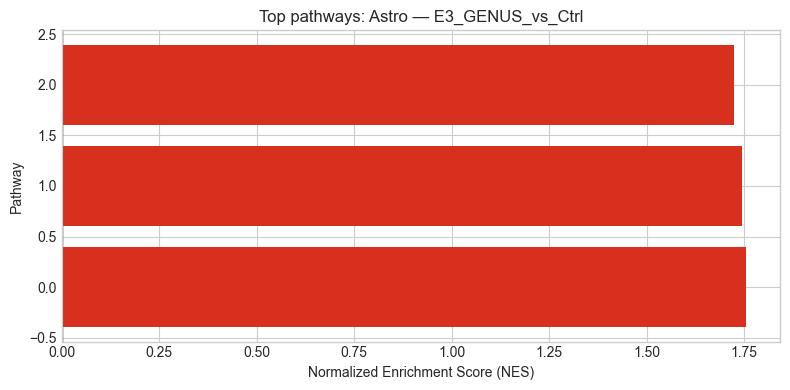

In [ ]:
plot_top_pathways(gsea_summary, cell_type="Astro", contrast="E3_GENUS_vs_Ctrl", max_terms=15)


In [38]:
"""
Visualization functions for pathway enrichment analysis across cell types.

This module provides functions to create comprehensive visualizations of
pathway enrichment results across multiple cell types and contrasts.
"""

from __future__ import annotations

from pathlib import Path
from typing import Dict, List, Optional

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


def _recover_pathway_names(
    results_df: pd.DataFrame,
    gene_sets: Optional[Dict[str, Dict[str, List[str]]]] = None,
) -> pd.DataFrame:
    """
    Recover pathway names for results that have numeric pathway identifiers.
    
    This function checks if pathway names are numeric and attempts to map them
    back to actual pathway names from gene_sets.
    
    Parameters:
    -----------
    results_df : pd.DataFrame
        GSEA summary dataframe with potentially numeric pathway identifiers
    gene_sets : Optional[Dict[str, Dict[str, List[str]]]]
        The gene sets dictionary used for GSEA (keys are collection names, values are pathway dicts)
        If None, will attempt to detect numeric pathway names but cannot recover them
    
    Returns:
    --------
    pd.DataFrame
        DataFrame with pathway names recovered (if possible)
    """
    if results_df.empty or "pathway" not in results_df.columns:
        return results_df
    
    recovered_df = results_df.copy()
    
    # Check if pathway column contains numeric values
    pathway_sample = recovered_df["pathway"].iloc[0] if len(recovered_df) > 0 else None
    
    # Check if pathways are numeric (integers or numeric strings)
    is_numeric = False
    if pathway_sample is not None:
        try:
            int(pathway_sample)
            is_numeric = True
        except (ValueError, TypeError):
            # Check if it's a numeric string representation
            if isinstance(pathway_sample, str) and pathway_sample.isdigit():
                is_numeric = True
    
    if not is_numeric:
        # Pathway names are already strings, no recovery needed
        return recovered_df
    
    if gene_sets is None:
        print("⚠️  Warning: Pathway names appear to be numeric, but gene_sets not provided.")
        print("   Cannot recover pathway names. Please provide gene_sets parameter or")
        print("   use recover_pathway_names() function from the notebook before plotting.")
        return recovered_df
    
    # Group by collection to map pathway indices to names
    for collection_name in recovered_df["collection"].unique():
        collection_mask = recovered_df["collection"] == collection_name
        
        if collection_name in gene_sets:
            pathway_list = list(gene_sets[collection_name].keys())
            
            # Map numeric pathway identifiers to actual names
            def map_pathway_name(row):
                try:
                    pathway_idx = int(row["pathway"])
                    if 0 <= pathway_idx < len(pathway_list):
                        return pathway_list[pathway_idx]
                    else:
                        return f"{collection_name}_pathway_{pathway_idx}"
                except (ValueError, TypeError):
                    # If pathway is already a string, return as-is
                    return row["pathway"]
            
            recovered_df.loc[collection_mask, "pathway"] = recovered_df[collection_mask].apply(
                map_pathway_name, axis=1
            )
        else:
            print(f"⚠️  Warning: Collection '{collection_name}' not found in gene_sets. Cannot recover pathway names.")
    
    return recovered_df


def plot_pathways_across_cell_types(
    results_df: pd.DataFrame,
    fdr_threshold: float = 0.1,
    max_pathways: int = 20,
    aggregation_method: str = "max_nes",
    collection_filter: Optional[str] = None,
    contrast_filter: Optional[str] = None,
    figsize: tuple = (14, 10),
    output_path: Optional[Path] = None,
    gene_sets: Optional[Dict[str, Dict[str, List[str]]]] = None,
) -> plt.Figure:
    """
    Create a comprehensive visualization of pathways across all cell types.
    
    Creates a heatmap showing pathways (rows) x cell types (columns) with
    color intensity representing Normalized Enrichment Score (NES).
    
    Parameters:
    -----------
    results_df : pd.DataFrame
        GSEA summary dataframe with columns: cell_type, contrast, pathway, nes, fdr, etc.
    fdr_threshold : float
        FDR threshold for filtering pathways
    max_pathways : int
        Maximum number of pathways to display
    aggregation_method : str
        How to aggregate pathways across contrasts: "max_nes", "mean_nes", or "min_fdr"
    collection_filter : Optional[str]
        Filter to specific collection (e.g., "Hallmark", "GO_Biological_Process")
    contrast_filter : Optional[str]
        Filter to specific contrast (e.g., "E3_GENUS_vs_Ctrl")
    figsize : tuple
        Figure size (width, height)
    output_path : Optional[Path]
        Path to save the figure
    gene_sets : Optional[Dict[str, Dict[str, List[str]]]]
        Gene sets dictionary used for GSEA. If provided, will automatically recover
        pathway names if they are numeric identifiers.
    
    Returns:
    --------
    plt.Figure
        The matplotlib figure object
    """
    if results_df.empty:
        print("No enrichment results to plot.")
        return None
    
    # Recover pathway names if needed
    results_df = _recover_pathway_names(results_df, gene_sets)
    
    # Filter data
    filtered_df = results_df[results_df["fdr"] <= fdr_threshold].copy()
    
    if collection_filter:
        filtered_df = filtered_df[filtered_df["collection"] == collection_filter]
    
    if contrast_filter:
        filtered_df = filtered_df[filtered_df["contrast"] == contrast_filter]
    
    if filtered_df.empty:
        print(f"No pathways pass filters (FDR ≤ {fdr_threshold})")
        return None
    
    # Aggregate pathways across contrasts for each cell type
    if aggregation_method == "max_nes":
        # For each pathway-cell_type combination, take the maximum absolute NES
        agg_df = (
            filtered_df.groupby(["pathway", "cell_type"])
            .agg({"nes": lambda x: x.loc[x.abs().idxmax()], "fdr": "min"})
            .reset_index()
        )
    elif aggregation_method == "mean_nes":
        agg_df = (
            filtered_df.groupby(["pathway", "cell_type"])
            .agg({"nes": "mean", "fdr": "min"})
            .reset_index()
        )
    elif aggregation_method == "min_fdr":
        # Take the NES value corresponding to the minimum FDR
        agg_df = (
            filtered_df.groupby(["pathway", "cell_type"])
            .apply(lambda x: x.loc[x["fdr"].idxmin()])
            .reset_index(drop=True)
        )
    else:
        raise ValueError(f"Unknown aggregation_method: {aggregation_method}")
    
    # Select top pathways based on maximum absolute NES across all cell types
    pathway_scores = agg_df.groupby("pathway")["nes"].apply(lambda x: x.abs().max()).sort_values(ascending=False)
    top_pathways = pathway_scores.head(max_pathways).index.tolist()
    
    # Create pivot table for heatmap: pathways x cell_types
    pivot_data = agg_df[agg_df["pathway"].isin(top_pathways)].pivot(
        index="pathway", columns="cell_type", values="nes"
    )
    
    # Sort pathways by their maximum absolute NES
    pivot_data["max_abs_nes"] = pivot_data.abs().max(axis=1)
    pivot_data = pivot_data.sort_values("max_abs_nes", ascending=False).drop(columns="max_abs_nes")
    
    # Create the figure
    fig, ax = plt.subplots(figsize=figsize)
    
    # Create heatmap
    vmax = pivot_data.abs().max().max()
    vmin = -vmax
    
    im = ax.imshow(pivot_data.values, aspect="auto", cmap="RdBu_r", vmin=vmin, vmax=vmax)
    
    # Set ticks and labels
    ax.set_xticks(range(len(pivot_data.columns)))
    ax.set_xticklabels(pivot_data.columns, rotation=45, ha="right")
    ax.set_yticks(range(len(pivot_data.index)))
    ax.set_yticklabels(pivot_data.index)
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax, label="Normalized Enrichment Score (NES)")
    
    # Add text annotations for significant values
    for i in range(len(pivot_data.index)):
        for j in range(len(pivot_data.columns)):
            value = pivot_data.iloc[i, j]
            if not pd.isna(value):
                # Only show text if value is significant
                if abs(value) > 1.0:
                    text_color = "white" if abs(value) > vmax * 0.6 else "black"
                    ax.text(j, i, f"{value:.2f}", ha="center", va="center", 
                           color=text_color, fontsize=8, fontweight="bold")
    
    ax.set_xlabel("Cell Type", fontsize=12, fontweight="bold")
    ax.set_ylabel("Pathway", fontsize=12, fontweight="bold")
    
    title = f"Pathway Enrichment Across Cell Types (FDR ≤ {fdr_threshold})"
    if collection_filter:
        title += f" - {collection_filter}"
    if contrast_filter:
        title += f" - {contrast_filter}"
    ax.set_title(title, fontsize=14, fontweight="bold", pad=20)
    
    plt.tight_layout()
    
    if output_path:
        output_path.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(output_path, dpi=300, bbox_inches="tight")
        print(f"Saved figure to {output_path}")
    
    return fig


def plot_pathways_by_cell_type_grid(
    results_df: pd.DataFrame,
    fdr_threshold: float = 0.1,
    max_pathways_per_cell: int = 10,
    collection_filter: Optional[str] = None,
    contrast_filter: Optional[str] = None,
    figsize_per_subplot: tuple = (8, 6),
    max_cols: int = 3,
    output_path: Optional[Path] = None,
    gene_sets: Optional[Dict[str, Dict[str, List[str]]]] = None,
) -> plt.Figure:
    """
    Create a grid of bar plots showing top pathways for each cell type.
    
    Parameters:
    -----------
    results_df : pd.DataFrame
        GSEA summary dataframe
    fdr_threshold : float
        FDR threshold for filtering pathways
    max_pathways_per_cell : int
        Maximum number of pathways to show per cell type
    collection_filter : Optional[str]
        Filter to specific collection
    contrast_filter : Optional[str]
        Filter to specific contrast
    figsize_per_subplot : tuple
        Size of each subplot
    max_cols : int
        Maximum number of columns in grid
    output_path : Optional[Path]
        Path to save the figure
    gene_sets : Optional[Dict[str, Dict[str, List[str]]]]
        Gene sets dictionary used for GSEA. If provided, will automatically recover
        pathway names if they are numeric identifiers.
    
    Returns:
    --------
    plt.Figure
        The matplotlib figure object
    """
    if results_df.empty:
        print("No enrichment results to plot.")
        return None
    
    # Recover pathway names if needed
    results_df = _recover_pathway_names(results_df, gene_sets)
    
    # Filter data
    filtered_df = results_df[results_df["fdr"] <= fdr_threshold].copy()
    
    if collection_filter:
        filtered_df = filtered_df[filtered_df["collection"] == collection_filter]
    
    if contrast_filter:
        filtered_df = filtered_df[filtered_df["contrast"] == contrast_filter]
    
    if filtered_df.empty:
        print(f"No pathways pass filters (FDR ≤ {fdr_threshold})")
        return None
    
    # Get unique cell types
    cell_types = sorted(filtered_df["cell_type"].unique())
    n_cells = len(cell_types)
    
    if n_cells == 0:
        print("No cell types found.")
        return None
    
    n_cols = min(max_cols, n_cells)
    n_rows = int(np.ceil(n_cells / n_cols))
    
    fig_width = figsize_per_subplot[0] * n_cols
    fig_height = figsize_per_subplot[1] * n_rows
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(fig_width, fig_height))
    
    if n_cells == 1:
        axes = [axes]
    else:
        axes = axes.flatten()
    
    # Plot each cell type
    for idx, cell_type in enumerate(cell_types):
        ax = axes[idx]
        
        cell_data = filtered_df[filtered_df["cell_type"] == cell_type].copy()
        
        # Aggregate across contrasts if needed
        if not contrast_filter and len(cell_data["contrast"].unique()) > 1:
            # Take pathway with maximum absolute NES
            cell_data = (
                cell_data.groupby("pathway")
                .apply(lambda x: x.loc[x["nes"].abs().idxmax()])
                .reset_index(drop=True)
            )
        
        # Get top pathways
        top_up = cell_data[cell_data["nes"] > 0].sort_values("nes", ascending=False).head(max_pathways_per_cell // 2)
        top_down = cell_data[cell_data["nes"] < 0].sort_values("nes", ascending=True).head(max_pathways_per_cell // 2)
        top_pathways = pd.concat([top_up, top_down]).sort_values("nes")
        
        if top_pathways.empty:
            ax.text(0.5, 0.5, f"No pathways\nFDR ≤ {fdr_threshold}", 
                   ha="center", va="center", transform=ax.transAxes)
            ax.set_title(cell_type, fontsize=10, fontweight="bold")
            ax.axis("off")
            continue
        
        # Create bar plot
        pathway_names = top_pathways["pathway"].astype(str)
        colors = top_pathways["nes"].apply(lambda x: "#d7301f" if x > 0 else "#225ea8")
        
        bars = ax.barh(range(len(pathway_names)), top_pathways["nes"], color=colors)
        ax.axvline(0, color="black", linewidth=0.8, linestyle="--", alpha=0.5)
        ax.set_yticks(range(len(pathway_names)))
        
        # Truncate long pathway names for display
        display_names = [name[:60] + "..." if len(name) > 60 else name for name in pathway_names]
        ax.set_yticklabels(display_names, fontsize=8)
        ax.set_xlabel("NES", fontsize=9)
        ax.set_title(cell_type, fontsize=10, fontweight="bold")
        ax.grid(axis="x", alpha=0.3, linestyle="--")
    
    # Hide unused subplots
    for idx in range(n_cells, len(axes)):
        axes[idx].axis("off")
    
    title = f"Top Pathways by Cell Type (FDR ≤ {fdr_threshold})"
    if collection_filter:
        title += f" - {collection_filter}"
    if contrast_filter:
        title += f" - {contrast_filter}"
    fig.suptitle(title, fontsize=14, fontweight="bold", y=0.995)
    
    plt.tight_layout()
    
    if output_path:
        output_path.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(output_path, dpi=300, bbox_inches="tight")
        print(f"Saved figure to {output_path}")
    
    return fig


/var/folders/tf/f0_f53l11hq_9x5t0_hxr66h0000gn/T/ipykernel_49192/1077838958.py:89: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['TNF-alpha Signaling via NF-kB' 'Hypoxia' 'Cholesterol Homeostasis' ...
 'mTORC1 Signaling' 'E2F Targets' 'Myc Targets V1']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  recovered_df.loc[collection_mask, "pathway"] = recovered_df[collection_mask].apply(


Saved figure to /Users/melissadu/Documents/projects/tsai-lab-scrna/cell_annotation_colab/outputs/pathway_enrichment/pathway_heatmap_all_cell_types.png


/var/folders/tf/f0_f53l11hq_9x5t0_hxr66h0000gn/T/ipykernel_49192/1077838958.py:89: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['TNF-alpha Signaling via NF-kB' 'Hypoxia' 'Cholesterol Homeostasis' ...
 'mTORC1 Signaling' 'E2F Targets' 'Myc Targets V1']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  recovered_df.loc[collection_mask, "pathway"] = recovered_df[collection_mask].apply(
/var/folders/tf/f0_f53l11hq_9x5t0_hxr66h0000gn/T/ipykernel_49192/1077838958.py:340: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.loc[x["nes"].abs().idxmax()])
/var/folders/tf/f0_f

Saved figure to /Users/melissadu/Documents/projects/tsai-lab-scrna/cell_annotation_colab/outputs/pathway_enrichment/pathway_grid_by_cell_type.png


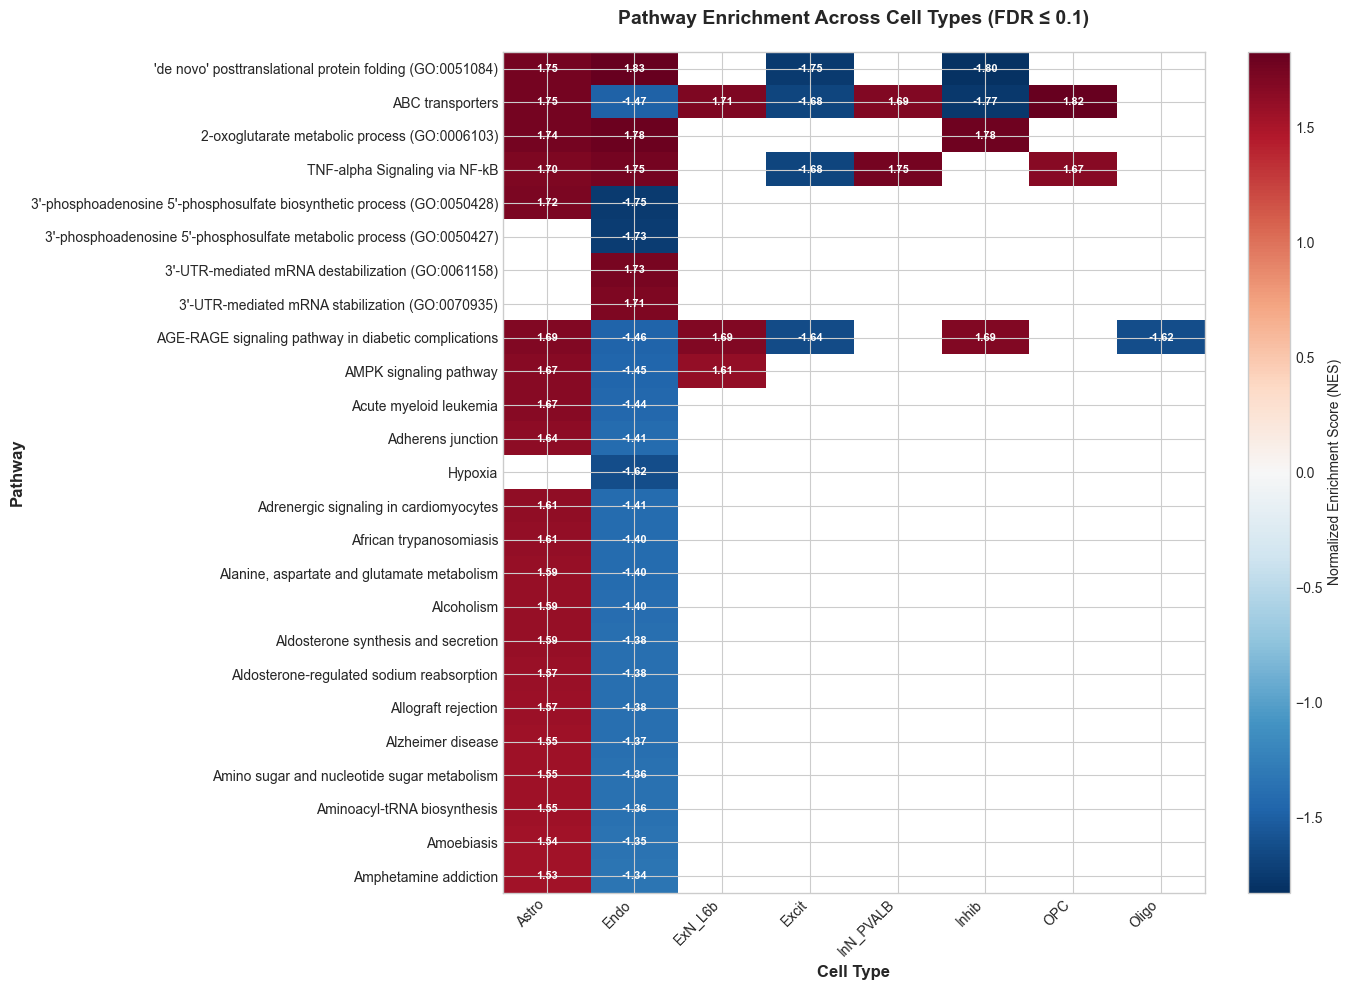

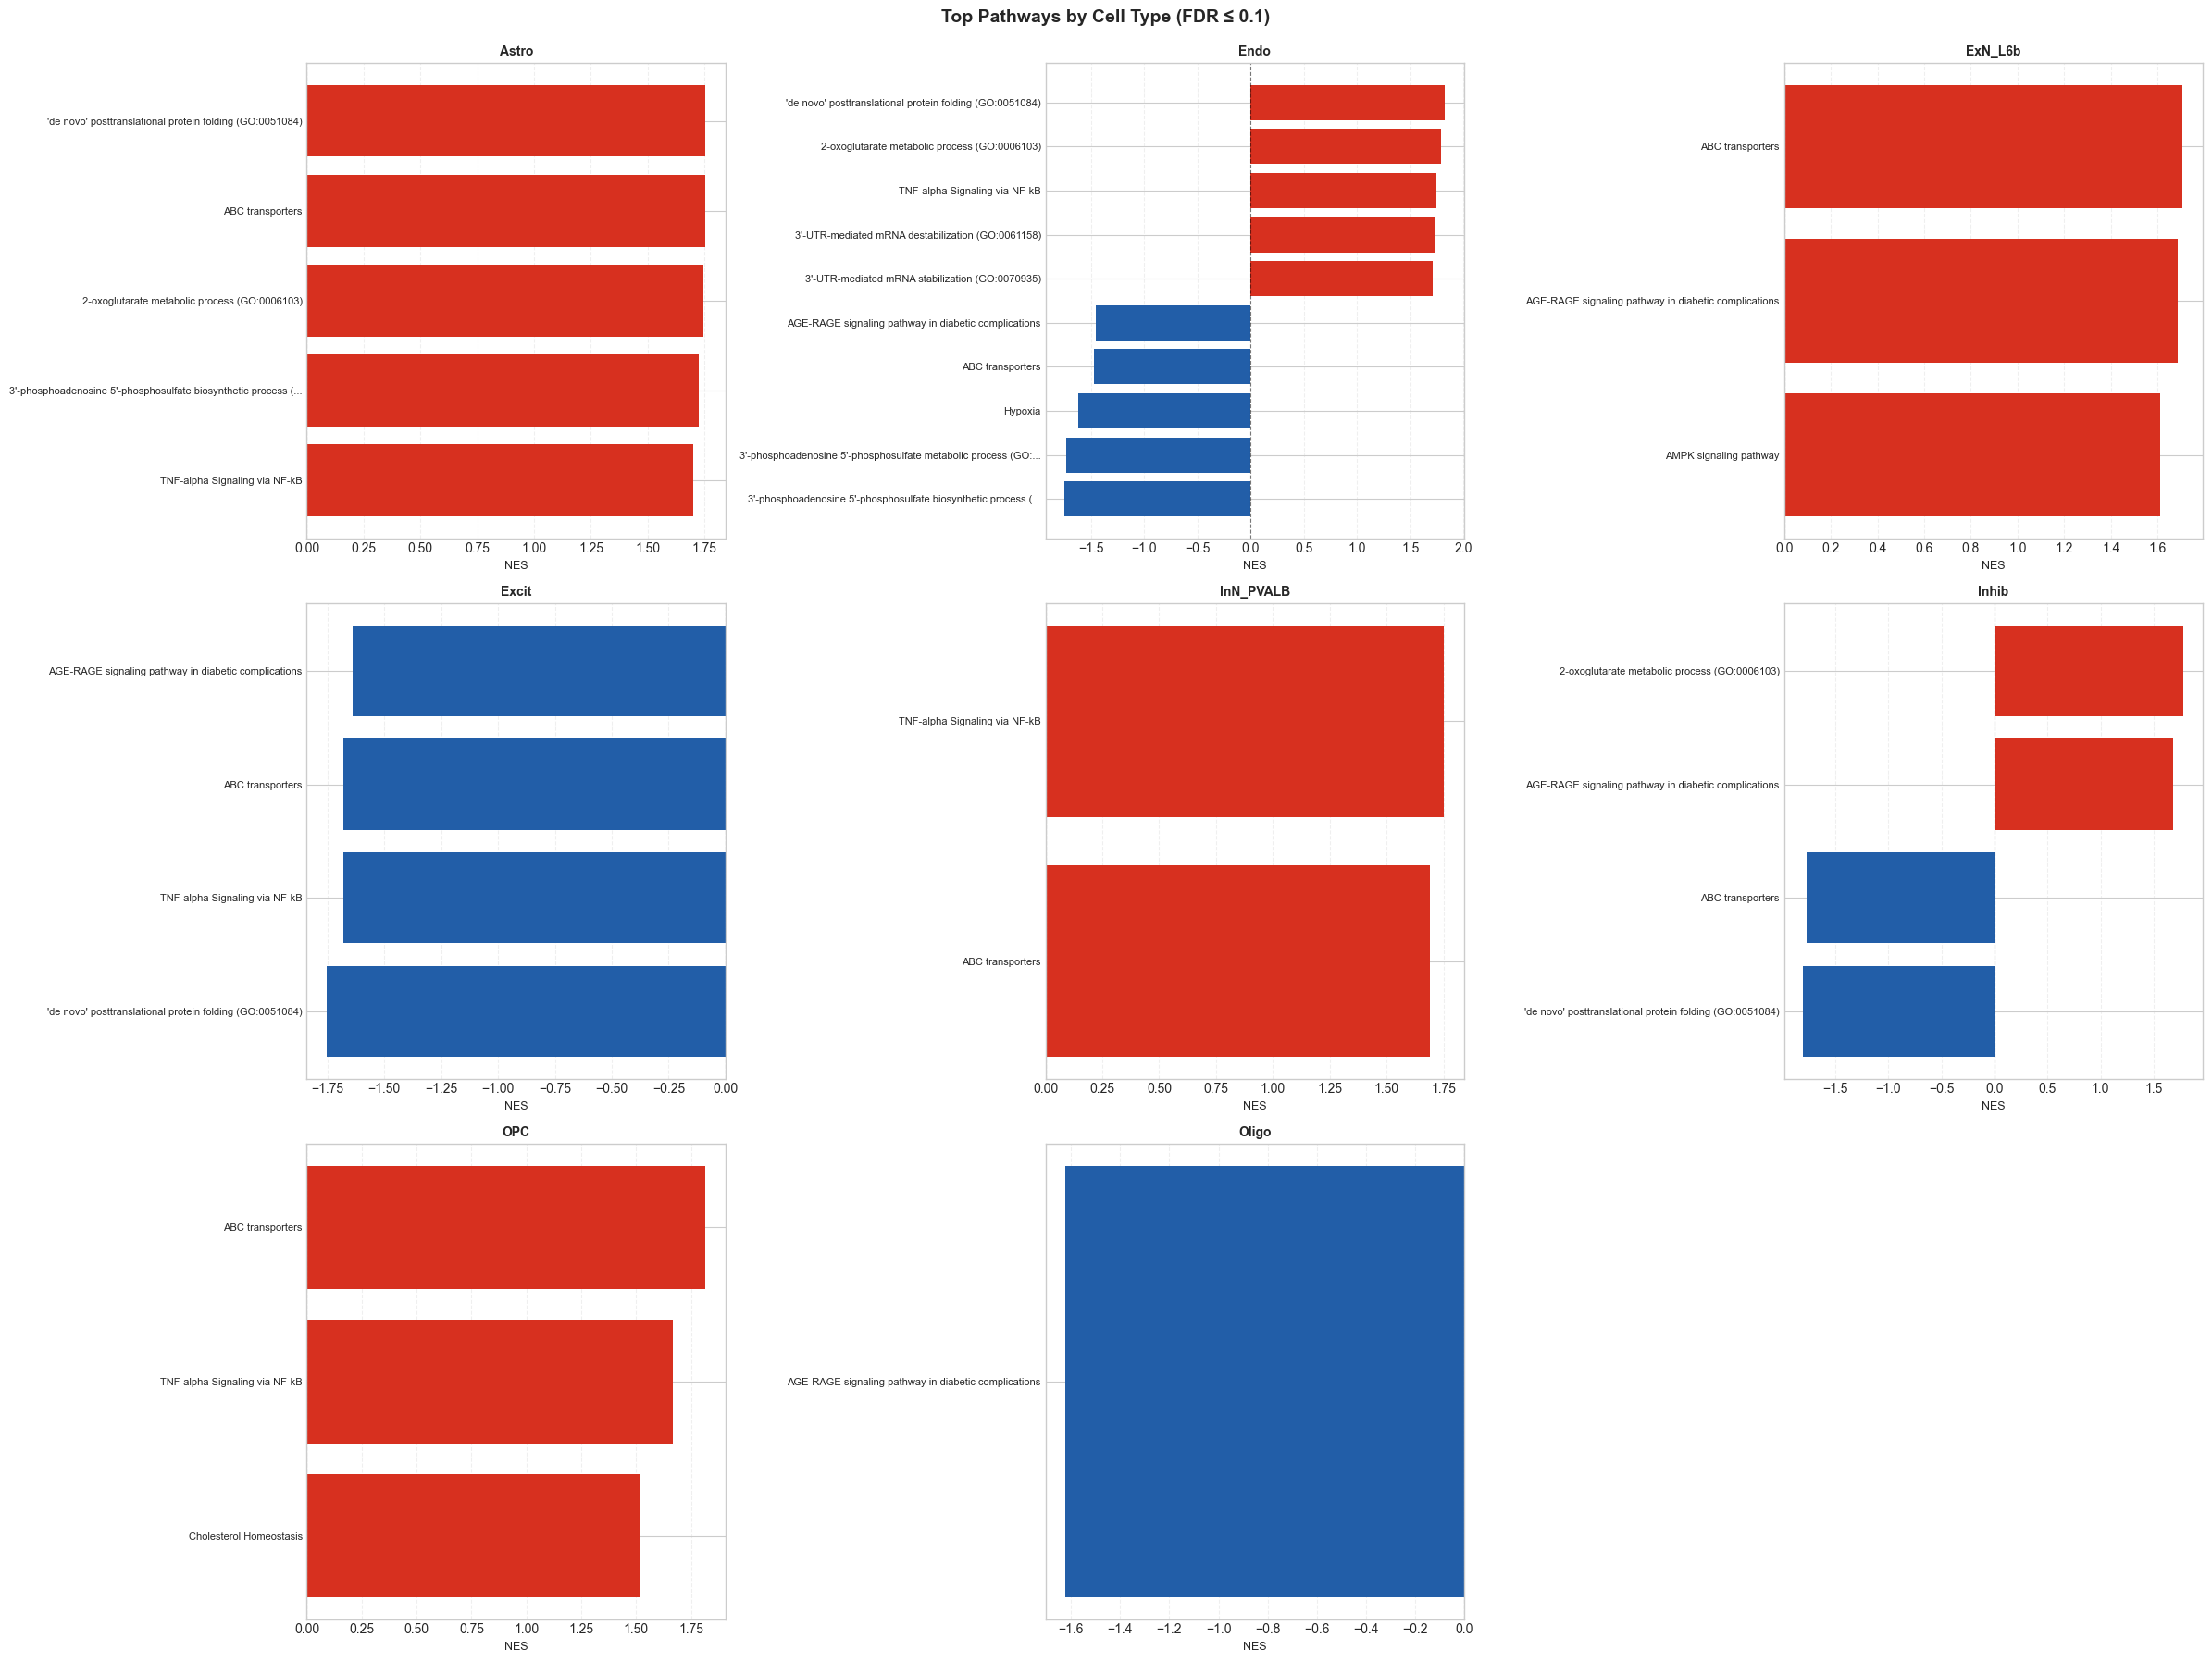

In [39]:


%reload_ext autoreload

fig1 = plot_pathways_across_cell_types(
    results_df=gsea_summary,
    fdr_threshold=0.1,
    max_pathways=25,
    output_path=OUTPUT_DIR / "pathway_heatmap_all_cell_types.png",
    gene_sets=gene_sets,
)

# Grid of bar plots
fig2 = plot_pathways_by_cell_type_grid(
    results_df=gsea_summary,
    fdr_threshold=0.1,
    max_pathways_per_cell=10,
    output_path=OUTPUT_DIR / "pathway_grid_by_cell_type.png",
    gene_sets=gene_sets,
)